# Imports

In [34]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# XGBoost
import xgboost as xgb

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Math utilities
import math

# Load Dataset

In [35]:
# Load the dataset
mortality_dataset = pd.read_csv('./datasets/Weekly_Provisional_Counts_of_Deaths_by_State_and_Select_Causes__2020-2023_20250216.csv')
mortality_dataset_illinois = mortality_dataset[mortality_dataset['Jurisdiction of Occurrence'] == 'Illinois']
climate_dataset = pd.read_csv('./datasets/Climate datasets/Data Cleaning/Climate_weekly_data.csv')

# Data Pre-Processing

In [36]:
# Code for cleaning individiual datasets
relevent_mortality_columns = [
    "Jurisdiction of Occurrence",
    "MMWR Year",
    "MMWR Week",
    "Week Ending Date",
    "All Cause",
    "Natural Cause",
    "Septicemia (A40-A41)",
    "Malignant neoplasms (C00-C97)",
    "Diabetes mellitus (E10-E14)",
    "Alzheimer disease (G30)",
    "Influenza and pneumonia (J09-J18)",
    "Chronic lower respiratory diseases (J40-J47)",
    "Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)",
    "Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)",
    "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)",
    "Diseases of heart (I00-I09,I11,I13,I20-I51)",
    "Cerebrovascular diseases (I60-I69)",
    "COVID-19 (U071, Multiple Cause of Death)",
    "COVID-19 (U071, Underlying Cause of Death)",
]
# Drop irrelevant columns from mortality dataset
mortality_dataset_illinois = mortality_dataset_illinois[relevent_mortality_columns]

# Create a new column called "Non Covid Deaths" that is equal to the "All Cause" column minus the COVID deaths column
mortality_dataset_illinois["Non Covid Deaths"] = mortality_dataset_illinois["All Cause"] - mortality_dataset_illinois["COVID-19 (U071, Underlying Cause of Death)"].fillna(0)

column_map = {
    "Week_Ending_Date": "Week Ending Date",
    "AWND": "Average Wind Speed (m/s)",
    "DAPR": "Number of days included in the multiday precipitation total",
    "MDPR": "Multiday precipitation total (mm)",
    "PRCP": "Precipitation (mm)",
    "SNOW": "Snowfall (cm)",
    "SNWD": "Snow Depth (cm)",
    "TAVG": "Average Temperature (C)",
    "TMAX": "Maximum Temperature (C)",
    "TMIN": "Minimum Temperature (C)",
    "TOBS": "Temperature Observed (C)",
}

# Drop irrelevant columns from climate dataset
climate_dataset = climate_dataset[column_map.keys()]
# Rename columns in climate dataset
climate_dataset.rename(columns=column_map, inplace=True)

# Convert columns to appropriate data types
mortality_dataset_illinois['Week Ending Date'] = pd.to_datetime(mortality_dataset_illinois['Week Ending Date'])
climate_dataset['Week Ending Date'] = pd.to_datetime(climate_dataset['Week Ending Date'])

# Filter the climate dataset to be till 2023-08-01 (Aug and Sept data has a lot of noise)
mortality_dataset_illinois = mortality_dataset_illinois[mortality_dataset_illinois['Week Ending Date'] < '2023-08-01']

# Merge Columns
merged_dataset = pd.merge(mortality_dataset_illinois, climate_dataset, on='Week Ending Date', how='inner')

In [37]:
label = ['Non Covid Deaths']

features = ['Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']

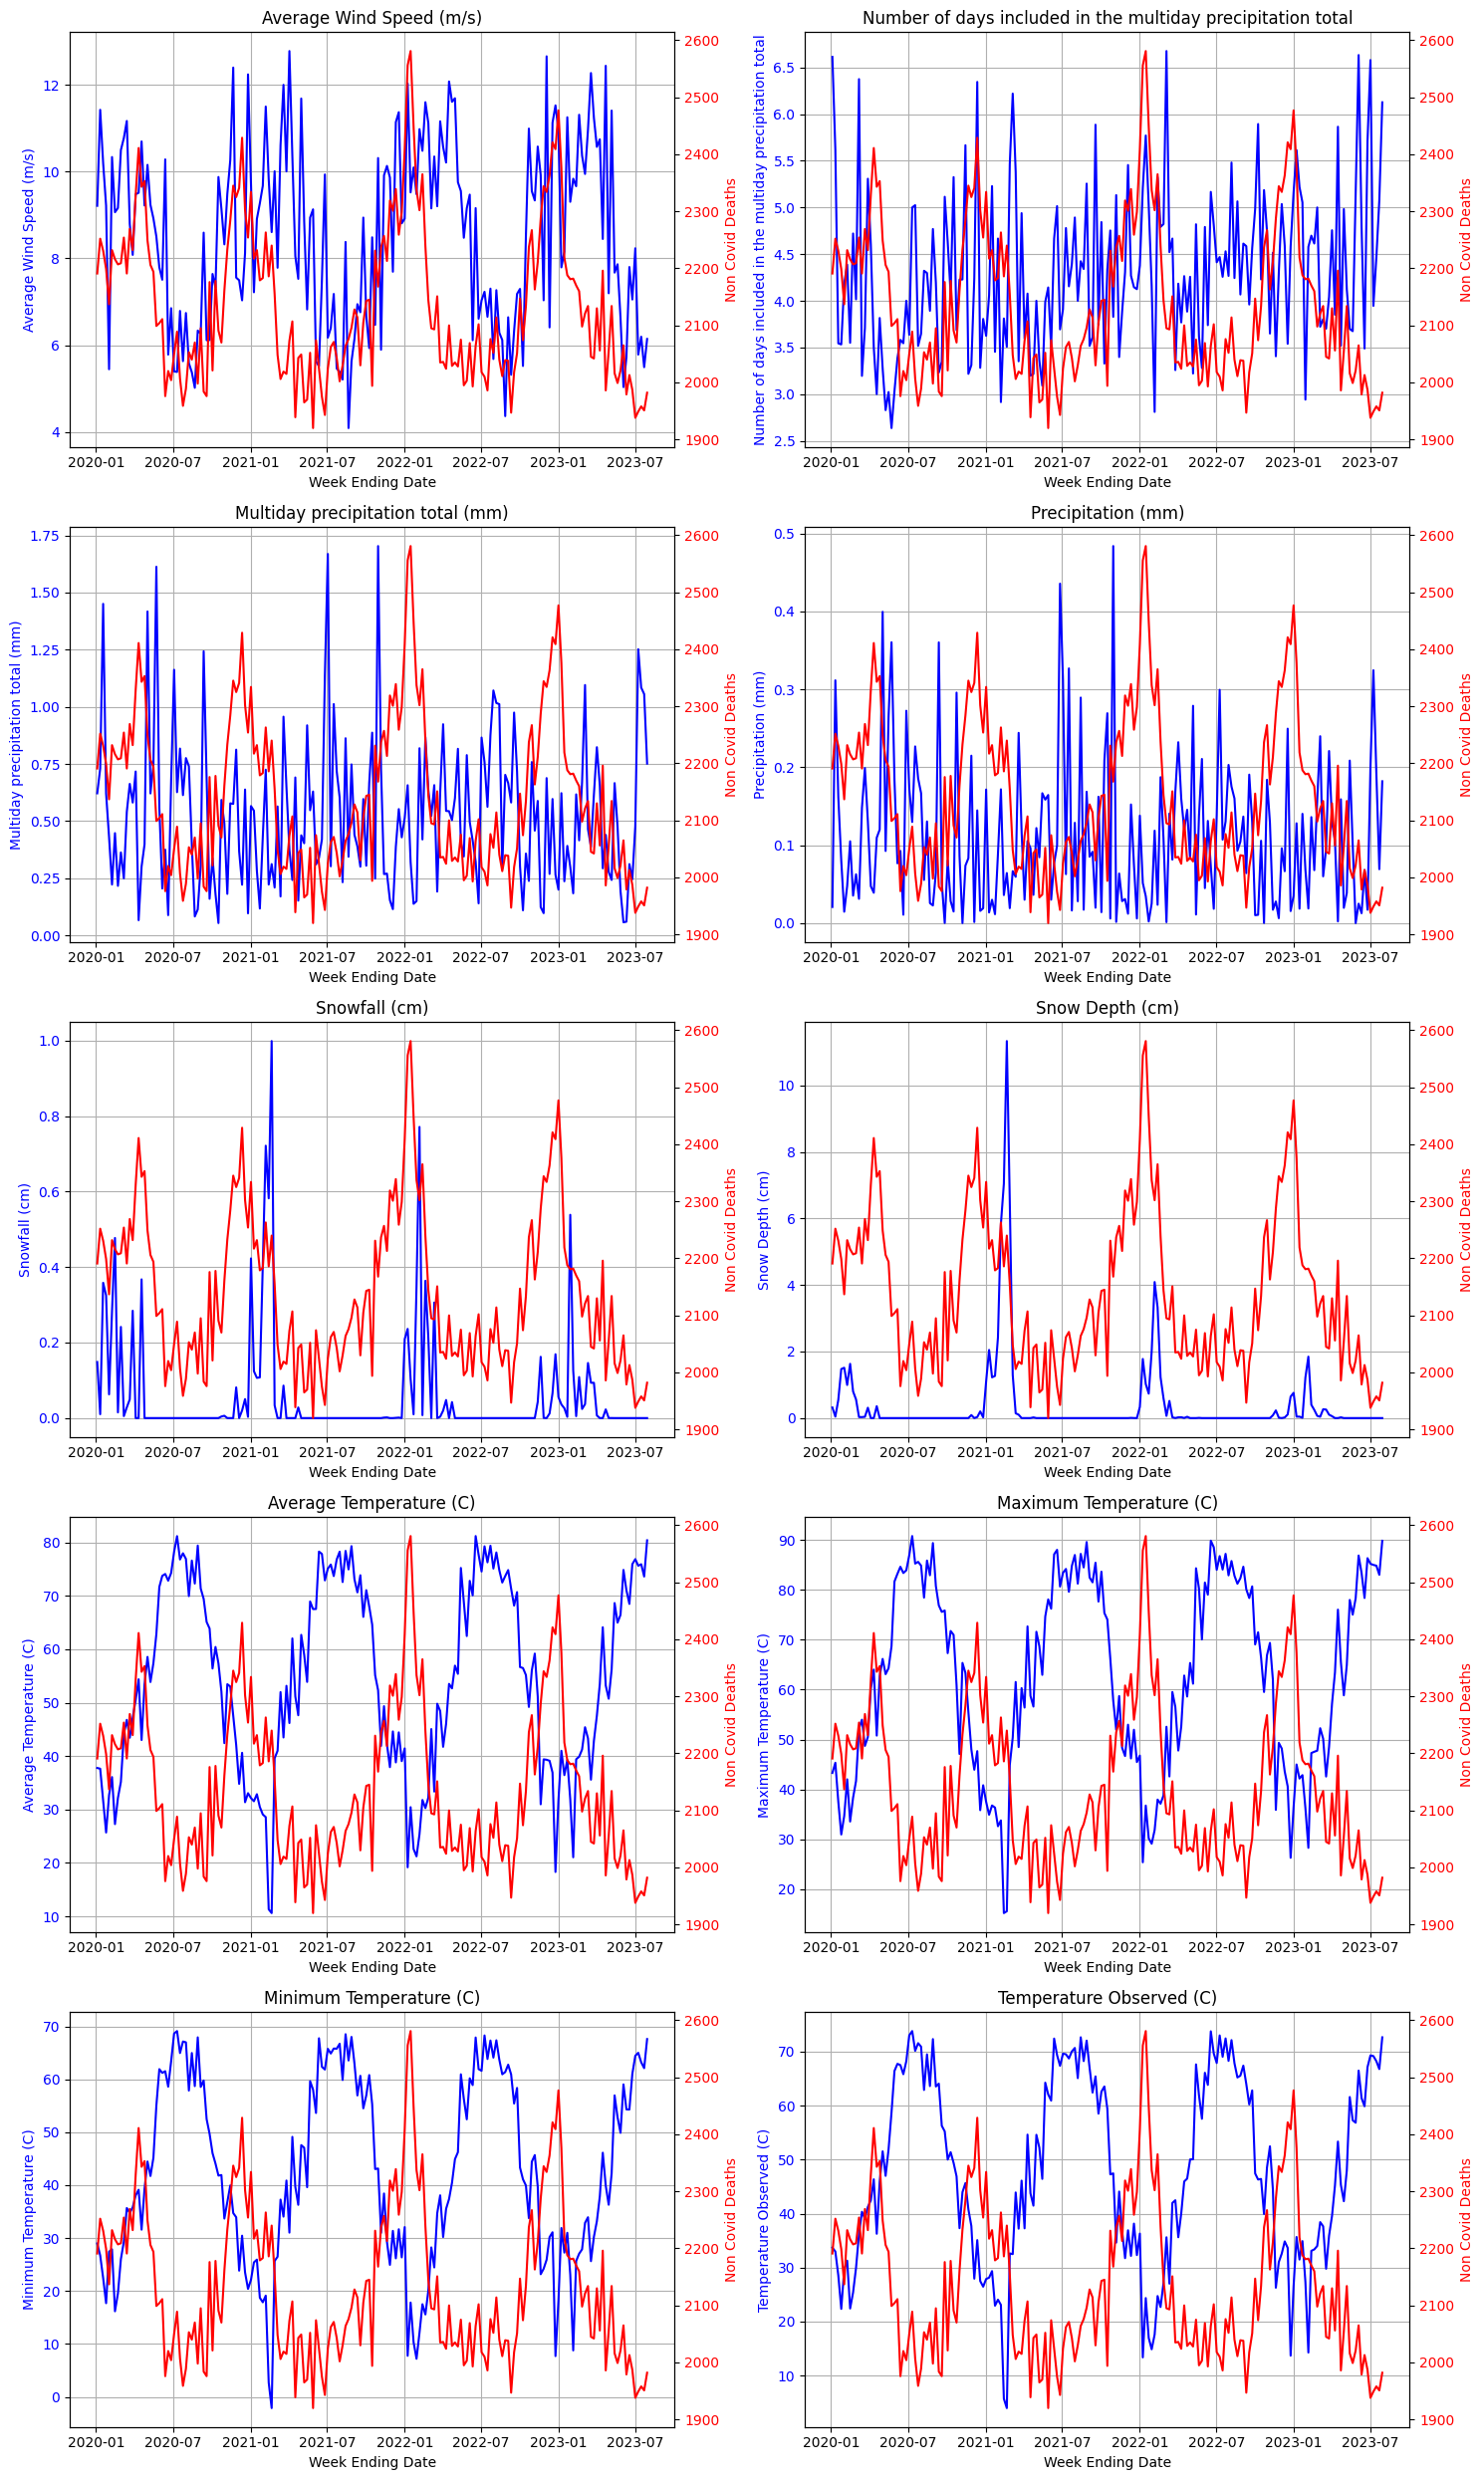

In [38]:
# Determine grid size
n_features = len(features)
n_cols = 2 
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(features):
    ax = axes[i]
    ax.plot(merged_dataset['Week Ending Date'], merged_dataset[column], color='blue', label=column)
    ax.set_xlabel('Week Ending Date')
    ax.set_ylabel(column, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f'{column}')
    ax.grid()

    # Create a twin y-axis for 'Non Covid Deaths'
    ax2 = ax.twinx()
    ax2.plot(merged_dataset['Week Ending Date'], merged_dataset['Non Covid Deaths'], color='red', label='Non Covid Deaths')
    ax2.set_ylabel('Non Covid Deaths', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Correlation

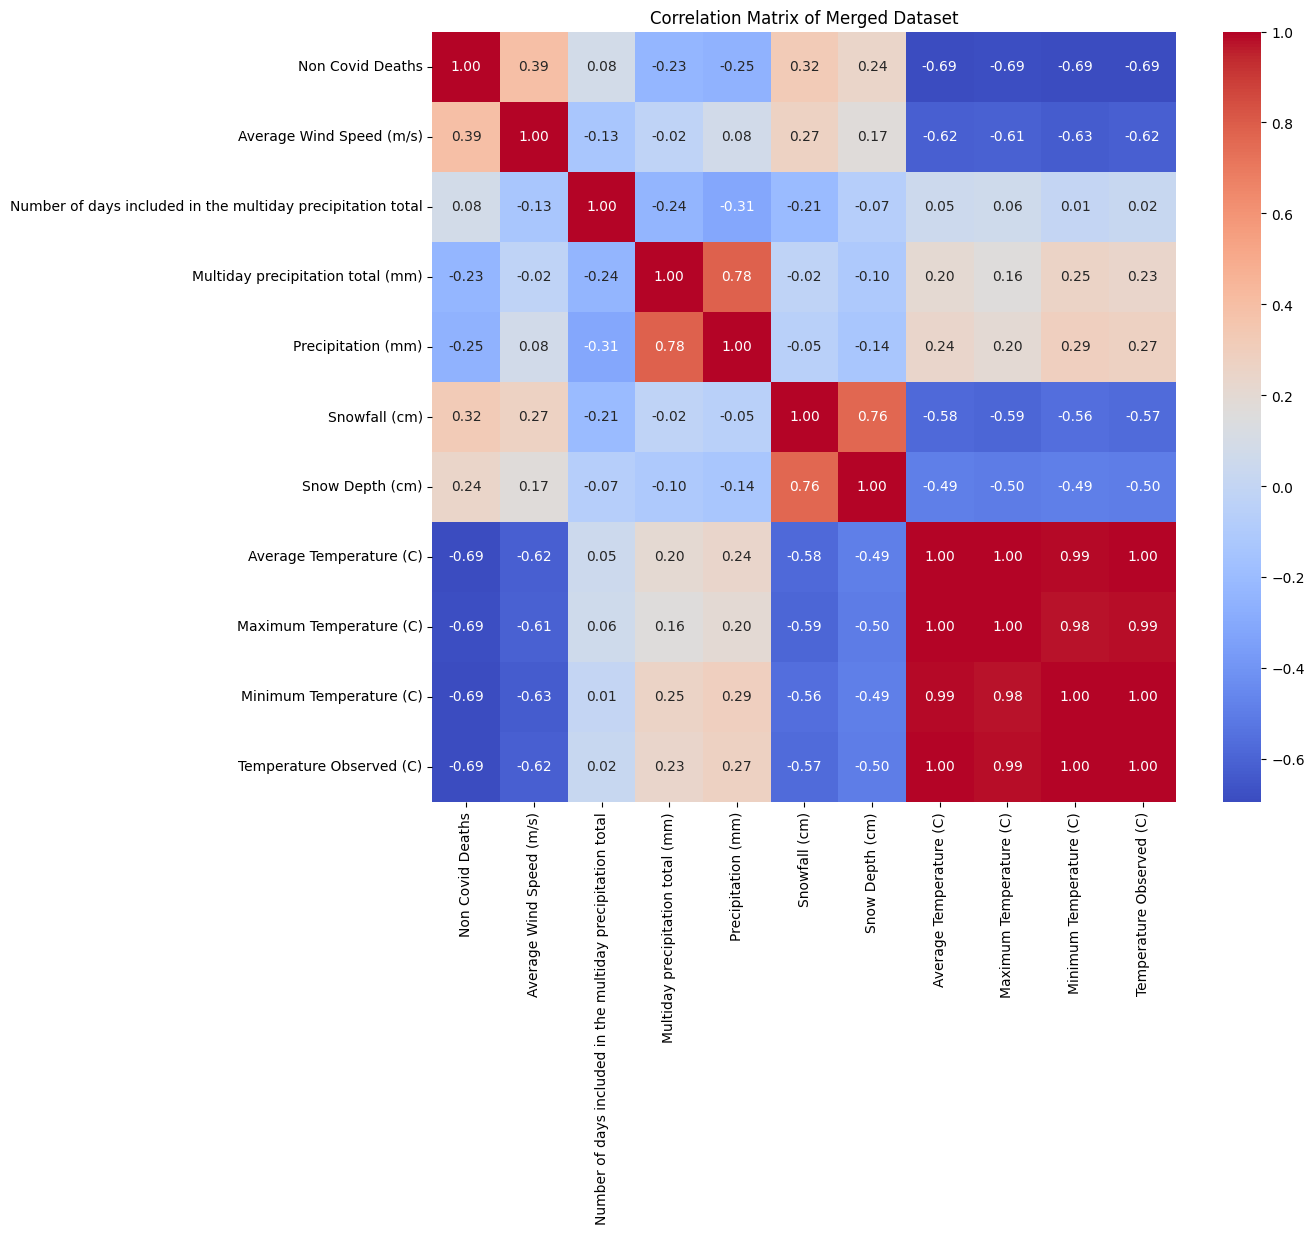

In [39]:
# Compute the correlation matrix for numeric columns only and only Non Covid Deaths
columns = ['Non Covid Deaths', 'Average Wind Speed (m/s)', 'Number of days included in the multiday precipitation total',
           'Multiday precipitation total (mm)', 'Precipitation (mm)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Maximum Temperature (C)', 'Minimum Temperature (C)', 'Temperature Observed (C)']
correlation_matrix = merged_dataset[columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Merged Dataset")
plt.show()

# Feature Engineering

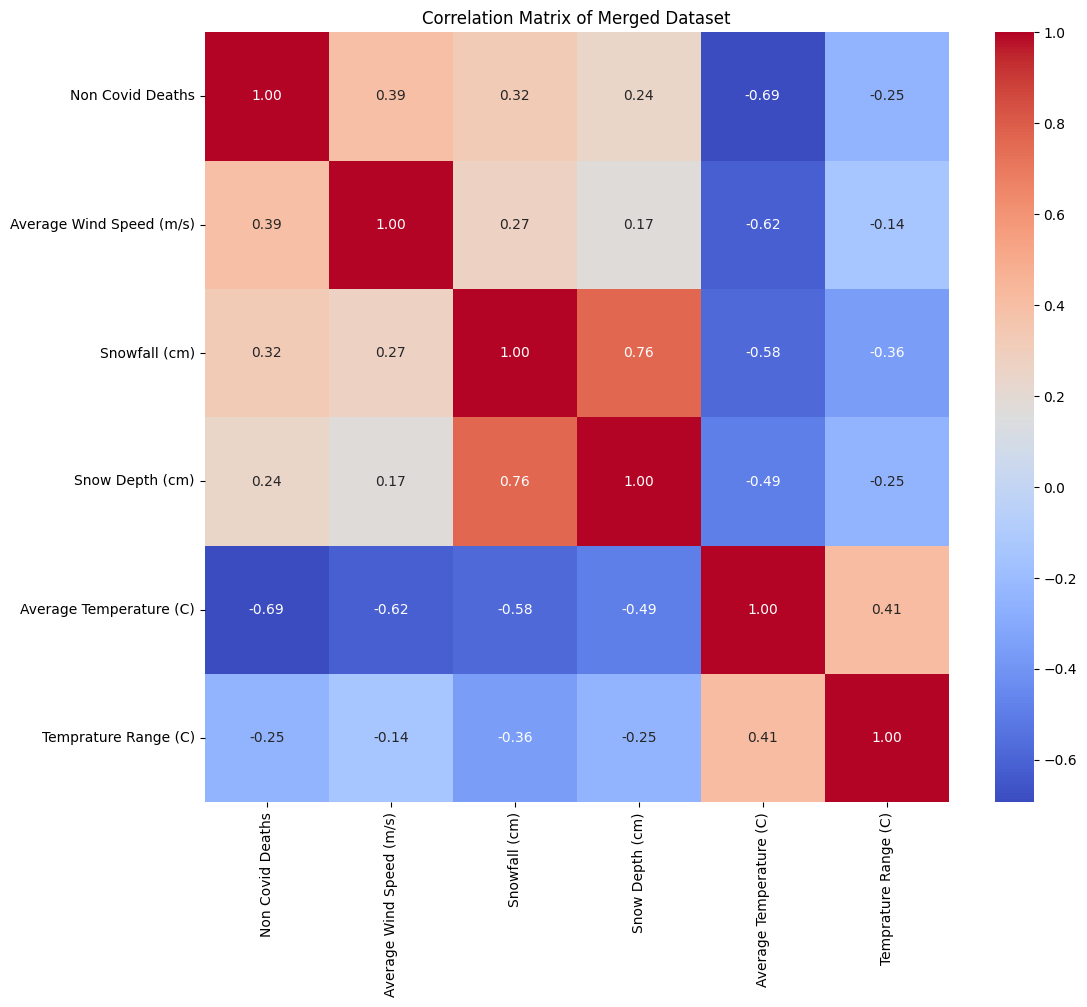

In [40]:
merged_dataset['Temprature Range (C)'] = merged_dataset['Maximum Temperature (C)'] - merged_dataset['Minimum Temperature (C)']

columns = ['Non Covid Deaths', 'Average Wind Speed (m/s)', 'Snowfall (cm)', 'Snow Depth (cm)',
           'Average Temperature (C)', 'Temprature Range (C)']

correlation_matrix = merged_dataset[columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Merged Dataset")
plt.show()

# Linear Model 

In [41]:
predictors = ['Average Wind Speed (m/s)', 'Snowfall (cm)', 'Snow Depth (cm)',
              'Average Temperature (C)', 'Temprature Range (C)']
label = 'Non Covid Deaths'

X = merged_dataset[predictors]
y = merged_dataset[label]

# Initialize and fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Use LassoCV to automatically select the best alpha
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_poly, y)

# Get predictions
y_pred = lasso_cv.predict(X_poly)

# Get selected features
feature_names = poly.get_feature_names_out(predictors)
selected_features = [name for name, coef in zip(feature_names, lasso_cv.coef_) if coef != 0]

# Calculate R² and adjusted R²
r2 = r2_score(y, y_pred)
n, p = X_poly.shape
p = len(selected_features)  # Number of selected features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)



# Output results
print("Selected Features:", selected_features)
print("Best alpha:", lasso_cv.alpha_)
print("R² Score:", r2) 
print("Adjusted R² Score:", adjusted_r2)

Selected Features: ['Average Temperature (C)', 'Snow Depth (cm)^2']
Best alpha: 13.427148474584328
R² Score: 0.48010026326442445
Adjusted R² Score: 0.4744491791694725


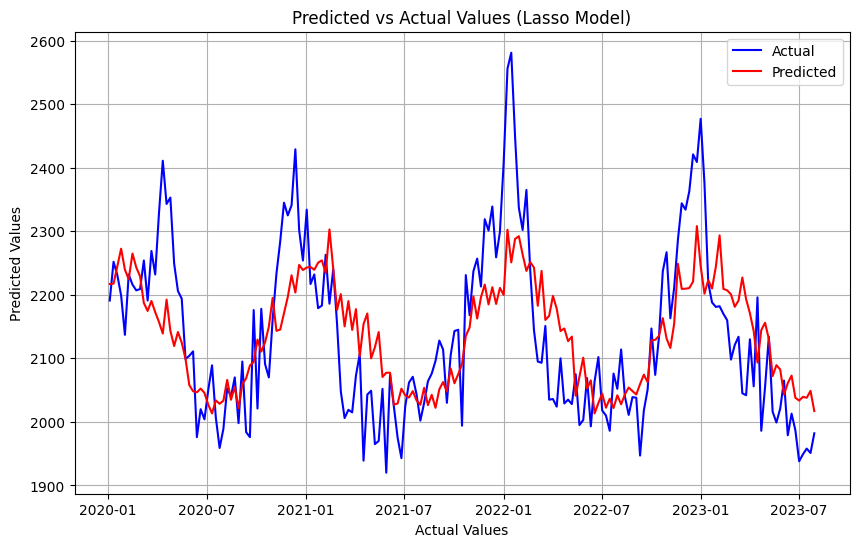

In [42]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(merged_dataset['Week Ending Date'], merged_dataset['Non Covid Deaths'], label='Actual', color='blue')
plt.plot(merged_dataset['Week Ending Date'], y_pred, label='Predicted', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Lasso Model)')
plt.legend()
plt.grid()
plt.show()

# Prophet Model to forecast Death Count

21:15:50 - cmdstanpy - INFO - Chain [1] start processing
21:15:50 - cmdstanpy - INFO - Chain [1] done processing


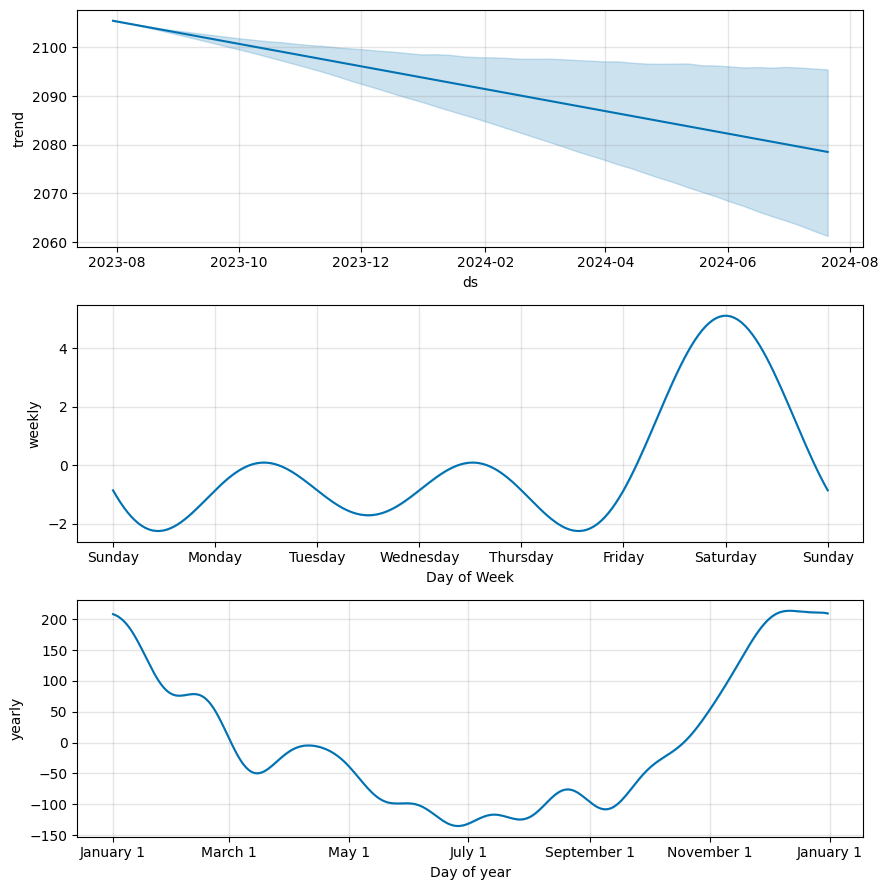

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/31 [00:00<?, ?it/s]21:15:51 - cmdstanpy - INFO - Chain [1] start processing
21:15:51 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 1/31 [00:00<00:07,  4.03it/s]21:15:51 - cmdstanpy - INFO - Chain [1] start processing
21:15:51 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 2/31 [00:00<00:07,  3.91it/s]21:15:51 - cmdstanpy - INFO - Chain [1] start processing
21:15:51 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 3/31 [00:00<00:07,  3.59it/s]21:15:51 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 4/31 [00:01<00:08,  3.29it/s]21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 5/31 [00:01<00:08,  3.06it/s]21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:

  horizon           mse        rmse        mae      mape     mdape     smape  \
0  3 days  13208.398876  114.927799  83.977088  0.038858  0.030185  0.039480   
1  4 days  15197.218483  123.276999  93.931202  0.043592  0.033973  0.043680   
2  5 days  14359.081159  119.829384  91.706361  0.042258  0.030034  0.042670   
3  6 days   6132.105969   78.307764  64.407164  0.030852  0.025859  0.030488   
4  7 days   6333.075379   79.580622  65.069462  0.031453  0.025859  0.031010   

   coverage  
0  0.692308  
1  0.630769  
2  0.615385  
3  0.723077  
4  0.692308  


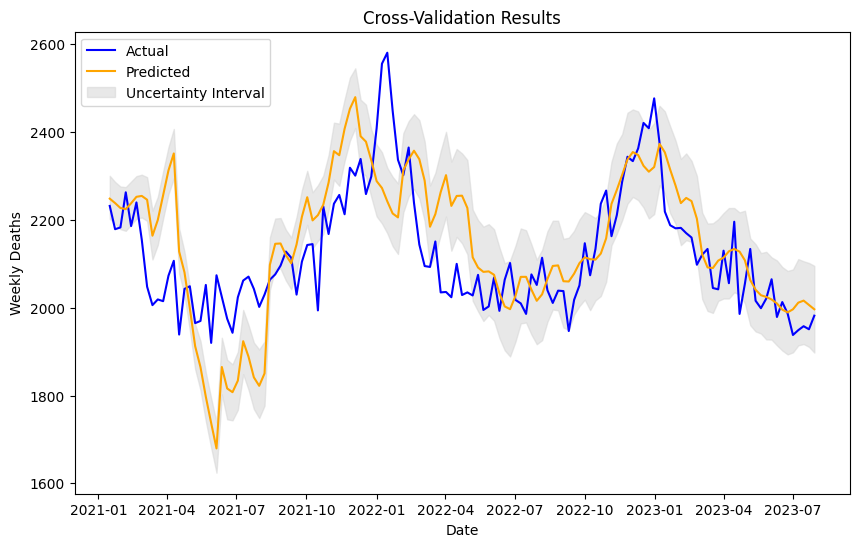

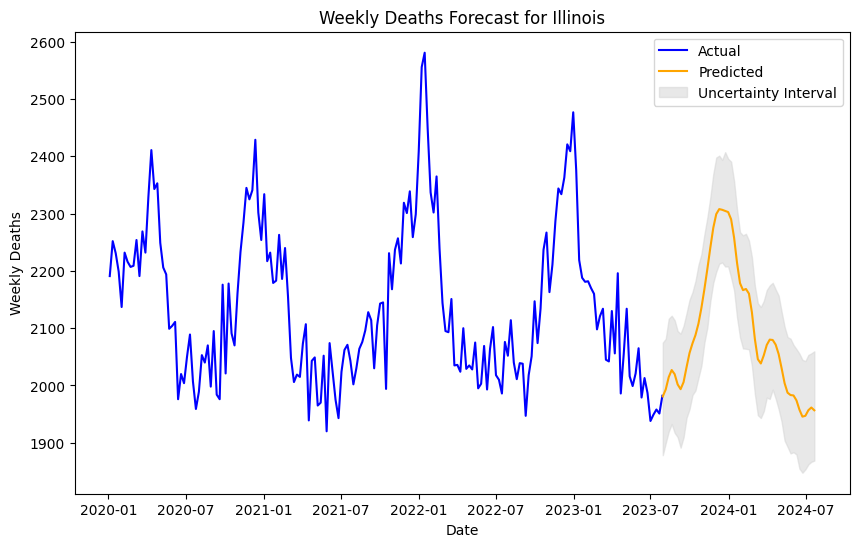

In [43]:
# Convert the date column to datetime format
prophet_dataset = mortality_dataset_illinois.rename(columns={'Week Ending Date': 'ds', 'Non Covid Deaths': 'y'}).copy()
prophet_dataset = prophet_dataset[['ds', 'y']].dropna()
prophet_dataset = prophet_dataset[(prophet_dataset['y'] > 0) & (prophet_dataset['y'] < 10000)]  # Filter rows with valid 'y' values

# Create a Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_dataset)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=52, freq='W')
future = future[future['ds'] > prophet_dataset['ds'].max()]
future = future[future['ds'] < prophet_dataset['ds'].max() + pd.DateOffset(weeks=52)]

# Make predictions
forecast = model.predict(future)

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()
# Cross-validation
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print(df_p.head())
# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual', color='blue')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted', color='orange')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Weekly Deaths')
plt.title('Cross-Validation Results')
plt.legend()
plt.show()

# Plot the forecast with uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(prophet_dataset['ds'], prophet_dataset['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Weekly Deaths')
plt.title('Weekly Deaths Forecast for Illinois')
plt.legend()
plt.show()

# Adding SocioEconomic data

In [44]:
# load the socioeconomic datasets
dp05 = pd.read_csv("datasets/Census/DP05/processed/DP05_combined.csv")
s1401 = pd.read_csv("datasets/Census/S1401/processed/S1401_combined.csv")
s2503 = pd.read_csv("datasets/Census/S2503/processed/S2503_combined.csv")

# Convert the 'Date' columns to datetime format
dp05["Date"] = pd.to_datetime(dp05["Date"])
s1401["Date"] = pd.to_datetime(s1401["Date"])
s2503["Date"] = pd.to_datetime(s2503["Date"])

# Merge the datasets on the 'Date' column
merged_socioeconomic = pd.merge(dp05, s1401, on="Date", how="inner")
merged_socioeconomic = pd.merge(merged_socioeconomic, s2503, on="Date", how="inner")

# Merge the climate dataset and mortality with the merged_socioeconomic_and_mortality on the 'Date' column
complete_dataset = pd.merge(
    merged_dataset,
    merged_socioeconomic,
    left_on="Week Ending Date",
    right_on="Date",
    how="inner",
)

relevant_columns = [
    "Jurisdiction of Occurrence",
    "Week Ending Date",
    "All Cause",
    "Natural Cause",
    "Non Covid Deaths",
    "Average Wind Speed (m/s)",
    "Precipitation (mm)",
    "Snowfall (cm)",
    "Snow Depth (cm)",
    "Average Temperature (C)",
    "Temprature Range (C)",
    "Total population",
    "Sex ratio",
    "Median age",
    "Under 18 years",
    "18 years and over",
    "62 years and over",
    "Total housing units",
    "Total enrolled in school",
    "Nursery school, preschool",
    "Kindergarten to 12th grade",
    "Kindergarten",
    "Elementary",
    "Middle school",
    "High school",
    "College, undergraduate",
    "Graduate, professional school",
    "Median_household_income",
    "Median_housing_costs"
]

# Filter the complete dataset to only include relevant columns
complete_dataset = complete_dataset[relevant_columns]


# Linear Model - Complete Dataset

In [45]:
label = ["Non Covid Deaths"]
features = [
    "Average Wind Speed (m/s)",
    "Precipitation (mm)",
    "Snowfall (cm)",
    "Snow Depth (cm)",
    "Average Temperature (C)",
    "Temprature Range (C)",
    "Total population",
    "Sex ratio",
    "Median age",
    "Under 18 years",
    "18 years and over",
    "62 years and over",
    "Total housing units",
    "Total enrolled in school",
    "Nursery school, preschool",
    "Kindergarten to 12th grade",
    "Kindergarten",
    "Elementary",
    "Middle school",
    "High school",
    "College, undergraduate",
    "Graduate, professional school",
    "Median_household_income",
    "Median_housing_costs",
]

# Create X and y
X = complete_dataset[features]
y = complete_dataset[label]

# Initialize and fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Use LassoCV to automatically select the best alpha
lasso_cv = LassoCV(cv=10, n_jobs=-1, max_iter=10000)
lasso_cv.fit(X_poly, y)

# Get predictions
y_pred = lasso_cv.predict(X_poly)

# Get selected features
feature_names = poly.get_feature_names_out(features)
selected_features = [
    name for name, coef in zip(feature_names, lasso_cv.coef_) if coef != 0
]

# Calculate R² and adjusted R²
r2 = r2_score(y, y_pred)
n, p = X_poly.shape
p = len(selected_features)  # Number of selected features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

# Output results
print("Selected Features:", selected_features)
print("Best alpha:", lasso_cv.alpha_)
print("R² Score:", r2)
print("Adjusted R² Score:", adjusted_r2)
print("RMSE:", rmse)
print("MAE:", mae)

c:\Users\mohi2\.conda\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mohi2\.conda\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.343e+02, tolerance: 3.220e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\mohi2\.conda\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e+02, tolerance: 2.882e+02
  model = cd_fast.enet_coordinate

Selected Features: ['Average Temperature (C)', 'Snow Depth (cm)^2', '18 years and over Total enrolled in school', 'Graduate, professional school^2']
Best alpha: 23.46432329045595
R² Score: 0.4682354075574252
Adjusted R² Score: 0.4565482736575883
RMSE: 98.26213370993167
MAE: 77.26862991259665


c:\Users\mohi2\.conda\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.941e+02, tolerance: 2.882e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\mohi2\.conda\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.826e+02, tolerance: 2.483e+02
  model = cd_fast.enet_coordinate_descent(


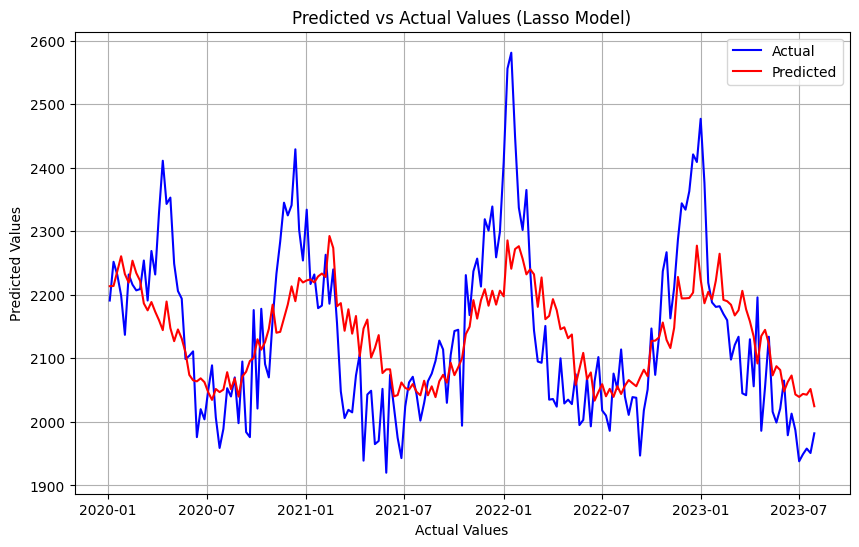

In [46]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(complete_dataset['Week Ending Date'], complete_dataset['Non Covid Deaths'], label='Actual', color='blue')
plt.plot(complete_dataset['Week Ending Date'], y_pred, label='Predicted', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Lasso Model)')
plt.legend()
plt.grid()
plt.show()

# XGBoost - Complete Dataset

In [47]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}

# Start with a smaller grid for performance, then refine
small_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=small_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X_train, y_train.values.ravel())
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Train final model with best parameters
best_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=20
)
best_model.fit(
    X_train,
    y_train.values.ravel(),
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

# Evaluate the model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
y_pred = best_model.predict(X_scaled_df)

# Calculate comprehensive metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y, y_pred)

print("\n===== Model Performance =====")
print("R² Score:", r2)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE: 8.674039540919264
[0]	validation_0-rmse:133.98706	validation_1-rmse:116.50456
[1]	validation_0-rmse:129.95481	validation_1-rmse:113.12845
[2]	validation_0-rmse:126.11035	validation_1-rmse:110.16515
[3]	validation_0-rmse:122.53418	validation_1-rmse:107.18859
[4]	validation_0-rmse:119.18269	validation_1-rmse:104.42653
[5]	validation_0-rmse:115.95436	validation_1-rmse:101.89762
[6]	validation_0-rmse:112.97580	validation_1-rmse:99.57958
[7]	validation_0-rmse:110.04407	validation_1-rmse:97.77052
[8]	validation_0-rmse:107.30574	validation_1-rmse:96.13321
[9]	validation_0-rmse:104.51811	validation_1-rmse:94.42711
[10]	validation_0-rmse:101.49206	validation_1-rmse:92.55294
[11]	validation_0-rmse:99.01348	validation_1-rmse:91.10271
[12]	validation_0-rmse:96.76926	validation_1-rmse:89.90738
[13]	validation_0-rmse:94.15145	validation_1-rmse:88.40144
[14]	validation_0-rmse:92.01606	validation

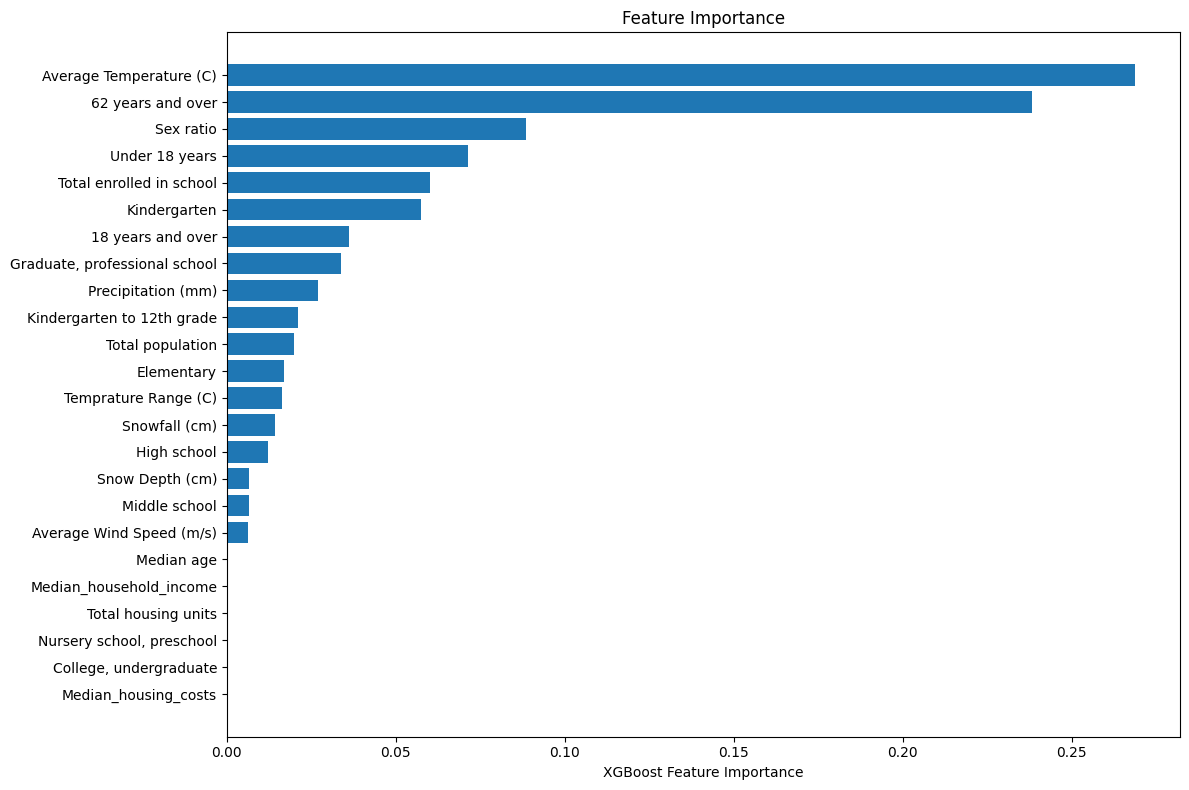

Text(0.5, 1.0, 'XGBoost RMSE')

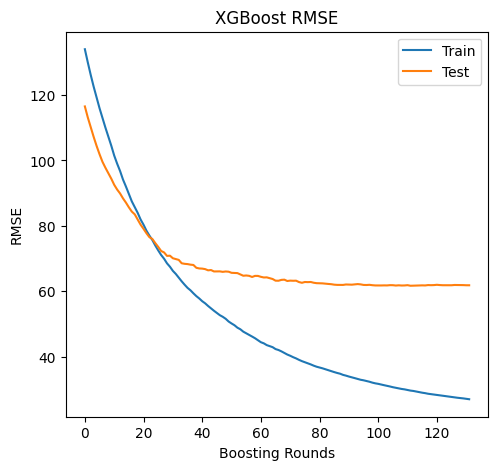

In [ ]:
# Feature importance visualization
plt.figure(figsize=(12, 8))
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# Learning curves
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

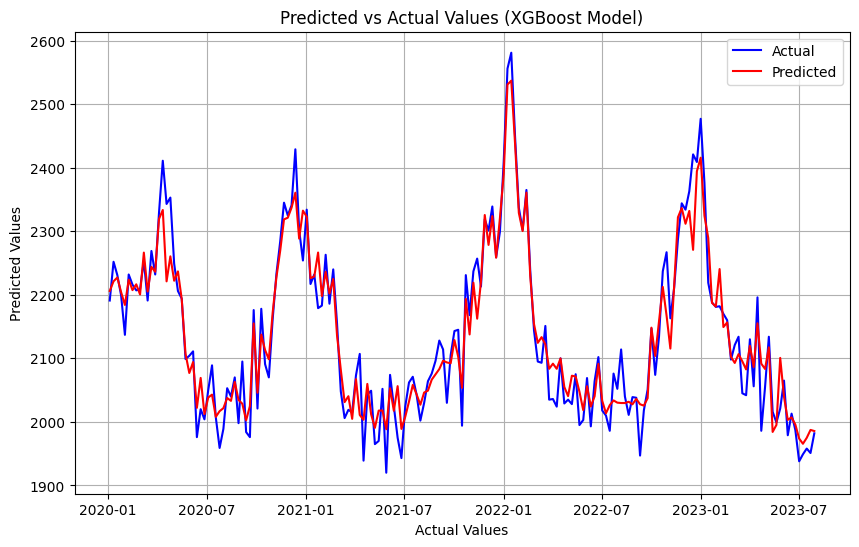

In [49]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(complete_dataset['Week Ending Date'], complete_dataset['Non Covid Deaths'], label='Actual', color='blue')
plt.plot(complete_dataset['Week Ending Date'], y_pred, label='Predicted', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (XGBoost Model)')
plt.legend()
plt.grid()
plt.show()
